<a href="https://colab.research.google.com/github/ravidkrisi/Deep-Learning-Introduction/blob/main/Random_Forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

we tried so solve the problem of Titanic from Kaggle with neural nets, actully the best way to solve this problem is by using Random Forests. Random forests use the principle of Descision Tree

## import and set up

### import libraries

In [1]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

### import dataset

mount google drive:

In [7]:
# Install the kaggle python library
!pip install -q kaggle

# Mount your Google Drive.
from google.colab import drive
drive.mount("/content/drive")

# create directory and add the API token
! mkdir ~/.kaggle

!cp /content/drive/MyDrive/'Colab_Notebooks'/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

#check if it worked
! kaggle datasets list

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                               title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/global-youtube-statistics-2023                   Global YouTube Statistics 2023                      60KB  2023-07-28 15:36:38           9266        306  1.0              
arjunajn/netflix-watch-log                                        Netflix Watch Log                                  295KB  2023-08-22 08:23:45            555         24  1.0              
kapturovalexander/gold-and-silver-prices-2013-2023     

download dataset from Kaggle:

In [8]:
! kaggle competitions download titanic

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 59.0MB/s]


unarchive file:

In [9]:
! unzip titanic.zip

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## Data Preprocessing

import `train.csv` and `test.csv` files:

In [11]:
df = pd.read_csv('train.csv')
tst_df = pd.read_csv('test.csv')

get all modes value of all columns:

In [13]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

create function to process the data:

In [14]:
def proc_data(df):
    df['Fare'] = df.Fare.fillna(0) # we want to fill null values in fare with 0
    df.fillna(modes, inplace=True) # fill all null values in all df with mode values
    df['LogFare'] = np.log1p(df['Fare']) # create new column of normalized fare
    df['Embarked'] = pd.Categorical(df.Embarked) # convert embarked column to numeric categorical
    df['Sex'] = pd.Categorical(df.Sex) # convert Sex column to numeric categorical

`.Categorical()`- convert a column to categorical type. it keeps the original value but behind the scenes they are stored as integers.

process both data frame of `train` and `test`:

In [ ]:
proc_data(df)
proc_data(tst_df)

make a list of categorical, continous and dependent variable:

In [20]:
cats=["Sex","Embarked"]
conts=['Age', 'SibSp', 'Parch', 'LogFare',"Pclass"]
dep="Survived"

split our data to training validation sets:

In [21]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)

replace in categorical columns original value with integer value, because its essential in some models:

In [22]:
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

create depenedent varibable and independent variables:

In [24]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [ ]:
preds = val_xs.Sex==0
preds

## Binary Split

using with Decision tree we need to identify the feature we want to split by and its threshold. the best way to split our data is that in each group we have to lowest score of impurity.

we will create function that score each group after the split:

In [26]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

and we will create function the calculate to score of the split by given feature and threshold:  

In [27]:
def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

defination of score: `score=0` the data is the most pure as possible. `score=1` data is the most impurity.

we will see the best threshold for the continous variables using interactive widget:

In [29]:
def iscore(nm, split):
    col = trn_xs[nm]
    return score(col, trn_y, split)

from ipywidgets import interact
interact(nm=conts, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('Age', 'SibSp', 'Parch', 'LogFare', 'Pclass'), value…

that was a nice visualization but if we had a lot of features and each one of them had a lot of unique values it would be really hard to do it manually. so let give the computer to compute the best threshold for each feature:

In [31]:
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique() # we will extract all unique values in a column
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)]) # we will calculate each threshold from the unique values
    idx = scores.argmin()
    return unq[idx],scores[idx]

lets try the function for all columns:

In [32]:
cols = cats+conts
{o:min_col(trn_df, o) for o in cols}

{'Sex': (0, 0.40787530982063946),
 'Embarked': (0, 0.47883342573147836),
 'Age': (6.0, 0.478316717508991),
 'SibSp': (4, 0.4783740258817434),
 'Parch': (0, 0.4805296527841601),
 'LogFare': (2.4390808375825834, 0.4620823937736597),
 'Pclass': (2, 0.46048261885806596)}

so what we created so far is OneR classifier. lets use it in order to create Desicion tree with several nodes. so we found that `Sex` is the best feature to split our data first. then our Data is split to `male` and `female`, now each group we need to find the best feature to split the group by:

In [33]:
cols.remove("Sex")
ismale = trn_df.Sex==1
males,females = trn_df[ismale],trn_df[~ismale]

find the best feature to split the `male` group:

In [34]:
{o:min_col(males, o) for o in cols}

{'Embarked': (0, 0.3875581870410906),
 'Age': (6.0, 0.3739828371010595),
 'SibSp': (4, 0.3875864227586273),
 'Parch': (0, 0.3874704821461959),
 'LogFare': (2.803360380906535, 0.3804856231758151),
 'Pclass': (1, 0.38155442004360934)}

we can see that `age>=6` is the best way to split the `male` group.
find the best feature to split the `female` group:

In [36]:
{o:min_col(females, o) for o in cols}

{'Embarked': (0, 0.4295252982857327),
 'Age': (50.0, 0.4225927658431649),
 'SibSp': (4, 0.42319212059713535),
 'Parch': (3, 0.4193314500446158),
 'LogFare': (4.256321678298823, 0.41350598332911376),
 'Pclass': (2, 0.3335388911567601)}

## Decision Tree

we found that `Pclass` is the best feature to split the `female` group by. now we need to continue this process to the groups we created. we can use `DecisionTreeClassifier` library that will do all this process for us now the we understand the underlaying math behind Decision Trees.

In [37]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

lets visualize the tree we created:

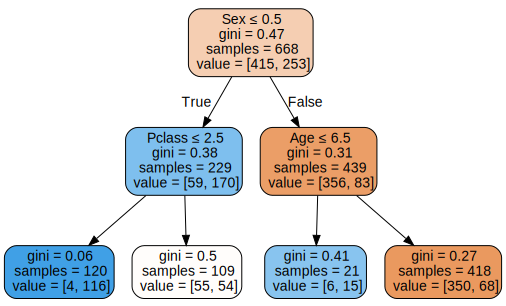

In [38]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))


draw_tree(m, trn_xs, size=10)

## Random Forest Tree

Random Forests tree is way of creating several Decision trees that each inculde a subset of the data and can take in consideration only a subset of the independent features. the prediction of random forest tree is the average prediction of all the forest.
lets create function that creates a  decision tree of a subset of the data:

In [41]:
def get_tree(prop=0.75):
    n = len(trn_y)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

lets create a forest of 100 decision trees:

In [42]:
trees = [get_tree() for t in range(100)]

lets predict using the forest we created:

In [47]:
from sklearn.metrics import mean_absolute_error

all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)
mean_absolute_error(val_y, avg_probs)

0.22726457399103137

in our scratch model we didn't select a subset of features columns to be measured by each tree. `RandomForestClassifier` can do it for us:

In [48]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf.predict(val_xs))

0.18834080717488788

we can see the improvement when we randomise the subset of the feature columns.